In [4]:
import seaborn as sns
import sys
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import matplotlib
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp, Trials

In [5]:
import pandas as pd
from google.colab import files

# Upload file manually
uploaded = files.upload()

# Get the uploaded file name
filename = list(uploaded.keys())[0]

# Read the file into a Pandas DataFrame
data = pd.read_csv(filename)

# Display the first few rows
data.head()


Saving output_file.csv to output_file (1).csv


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
data.columns = ['id','age','gender','height','weight','ap_hi','ap_lo','cholestrol', 'gluc',
                'smoke', 'alco', 'active', 'cardio']

In [7]:
data.shape

(70000, 13)

In [8]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholestrol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholestrol,gluc,smoke,alco,active,cardio
69995,99993,53.0,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,62.0,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52.0,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61.0,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,56.0,1,170,72.0,120,80,2,1,0,0,1,0


In [10]:
# Total Percentage of Missing Data
missing_data = data.isnull().sum()
total_percentage = (missing_data.sum()/data.shape[0]) * 100
print(f'The total percentage of missing data is {round(total_percentage,2)}%')

The total percentage of missing data is 0.0%


<ipython-input-11-70d3c33cd0b8>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax = ax)


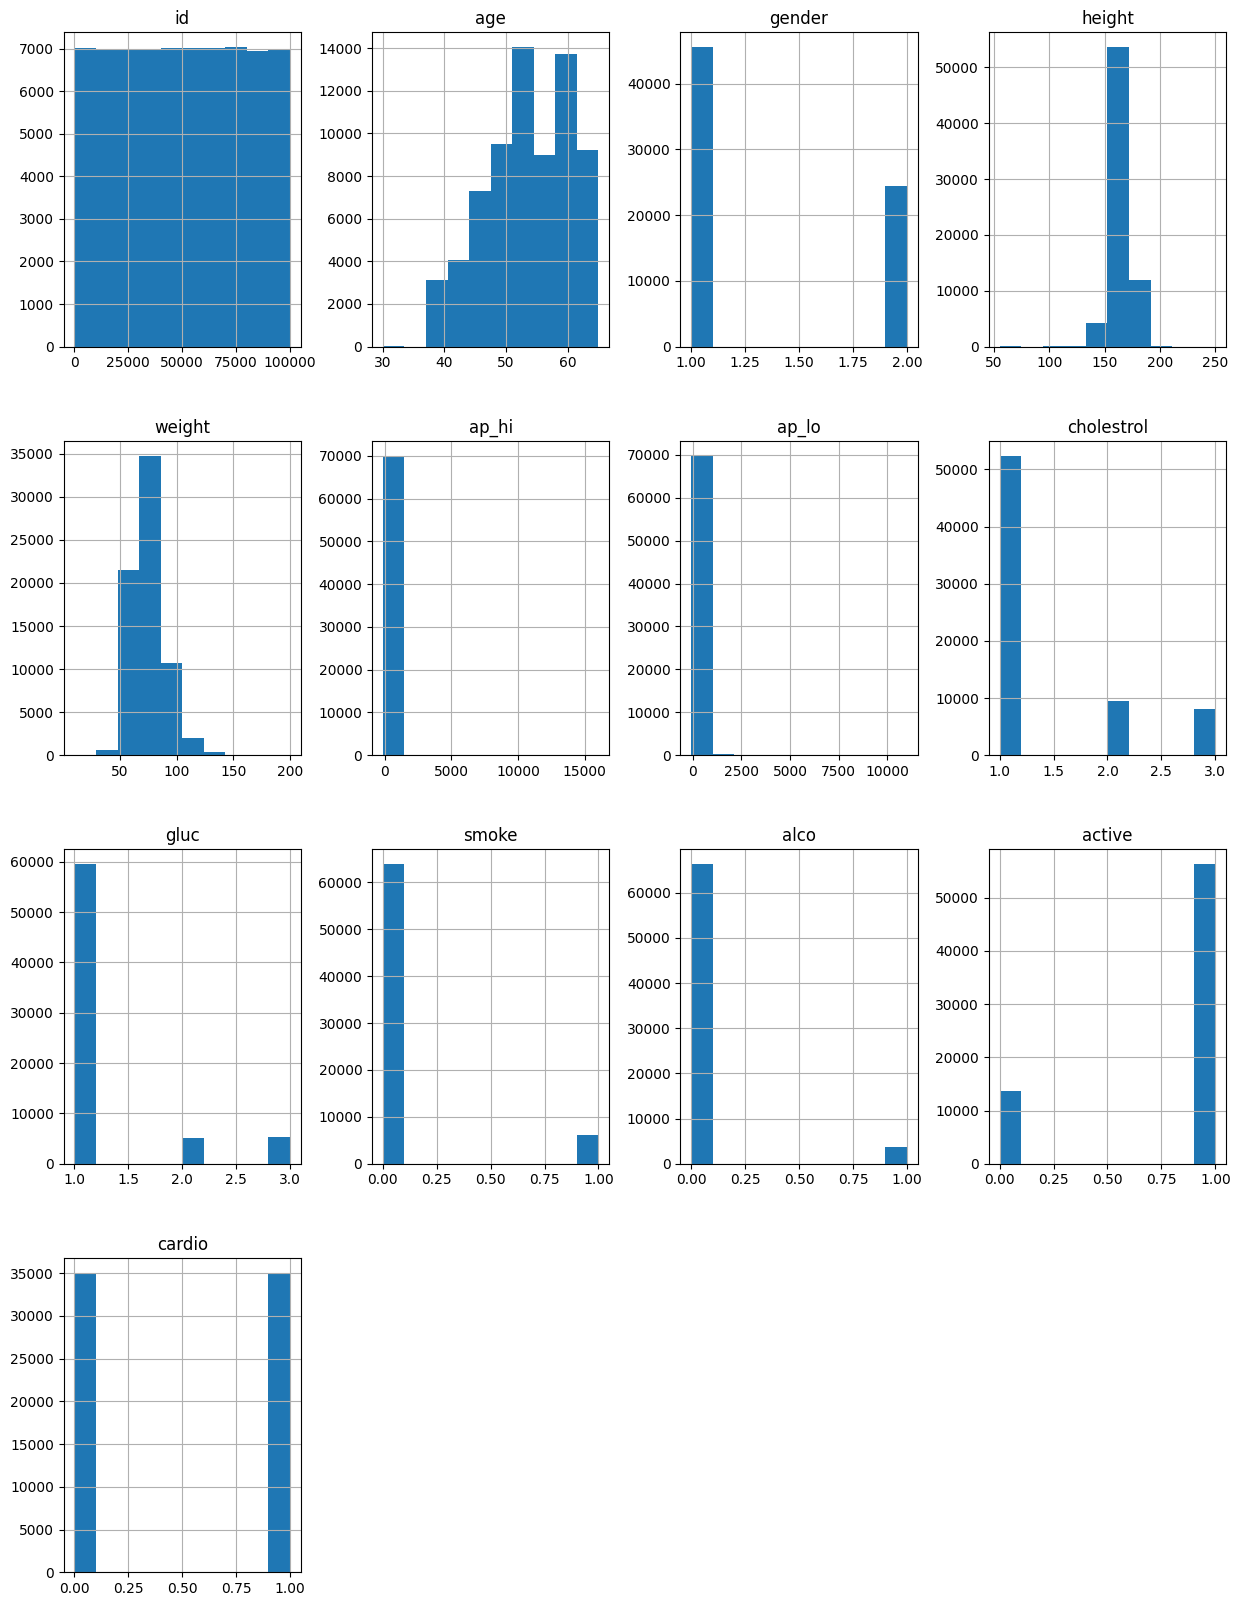

In [11]:
# Plot Histogram to See the Distribution of the Data

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)
plt.show()

<ipython-input-12-1afc555b9e75>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dataset_copy.hist(ax = ax)


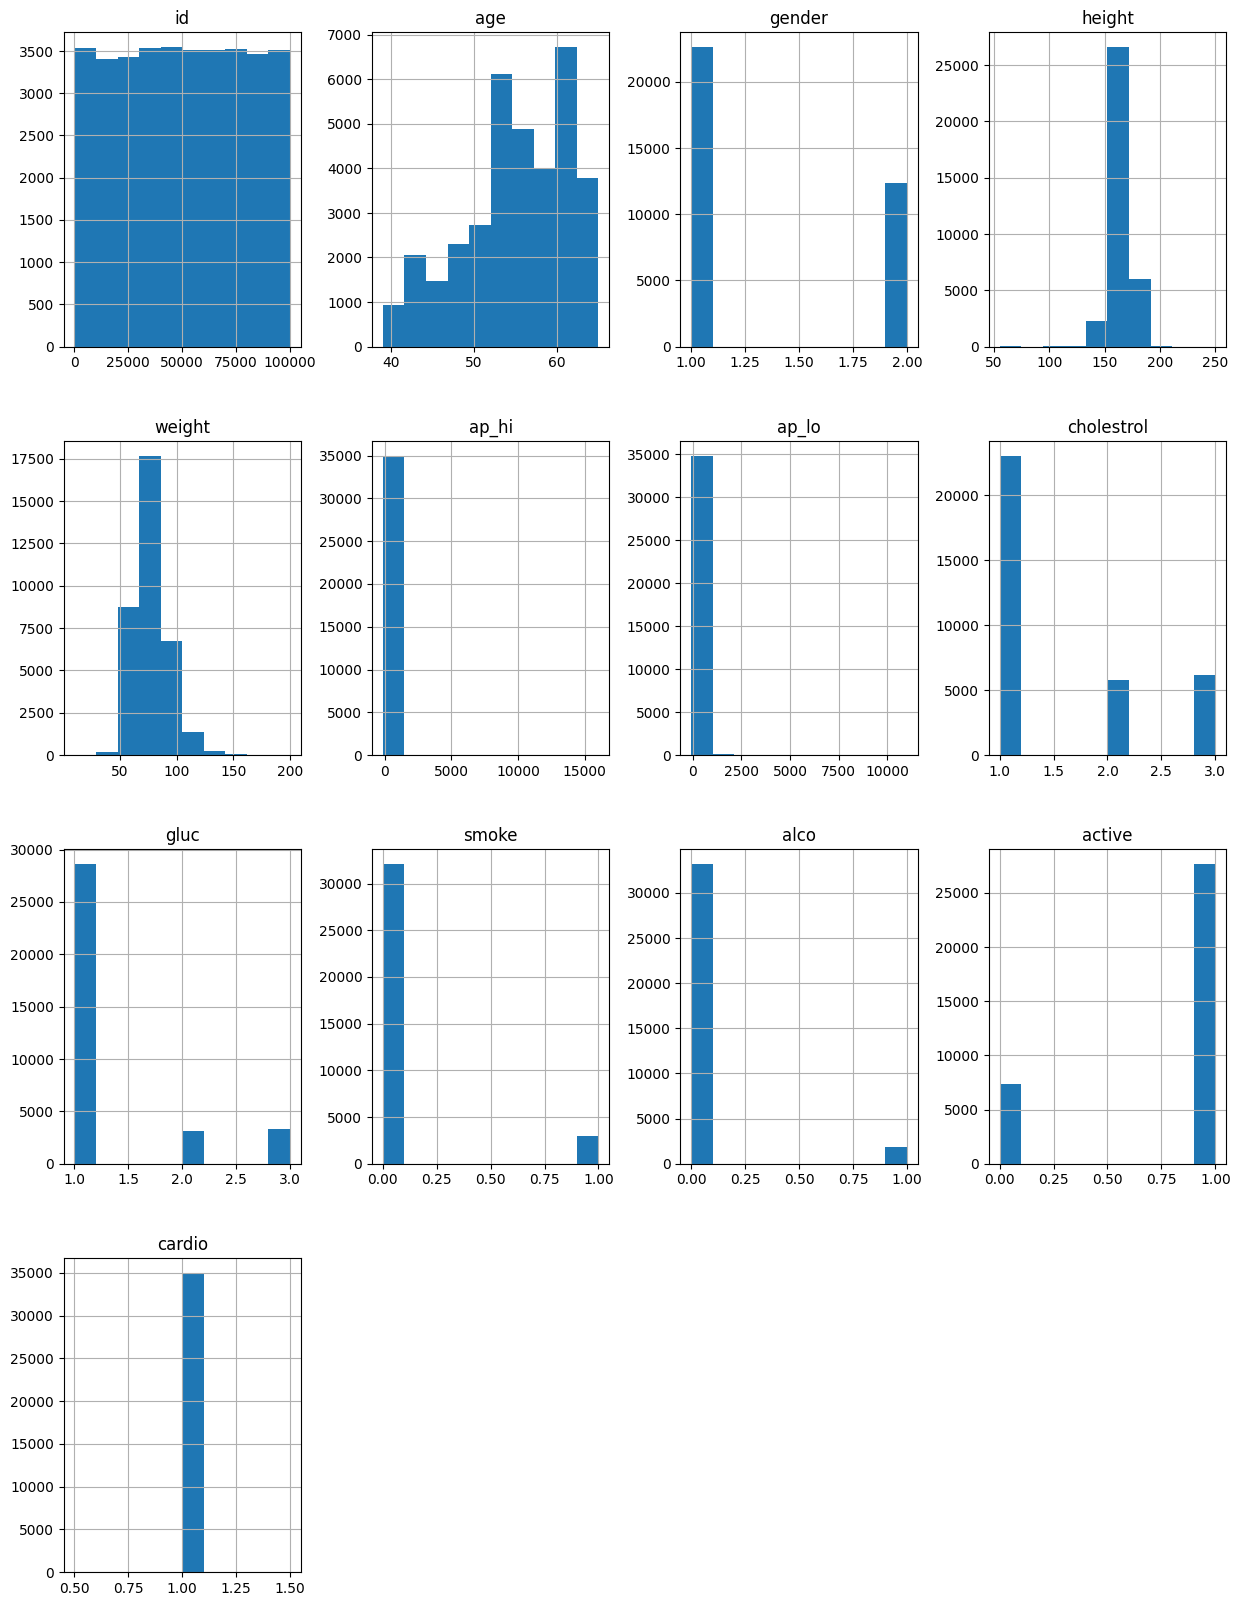

In [12]:
# Plot Histogram to See the Distribution of the Data for Heart Disease Cases
dataset_copy=data[data['cardio']==1]
columns=data.columns[:21]
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
dataset_copy.hist(ax = ax)
plt.show()

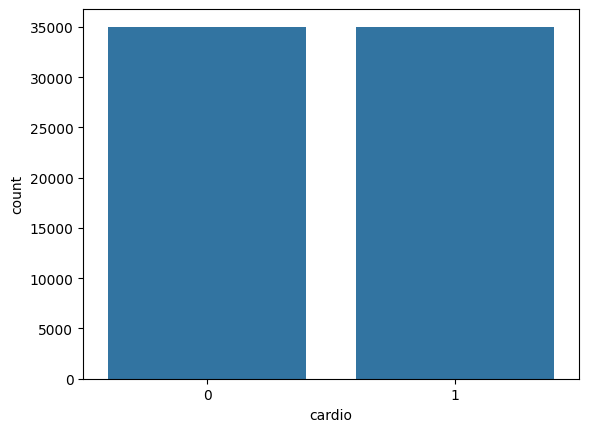

In [13]:
sns.countplot(x='cardio',data=data)
plt.show()

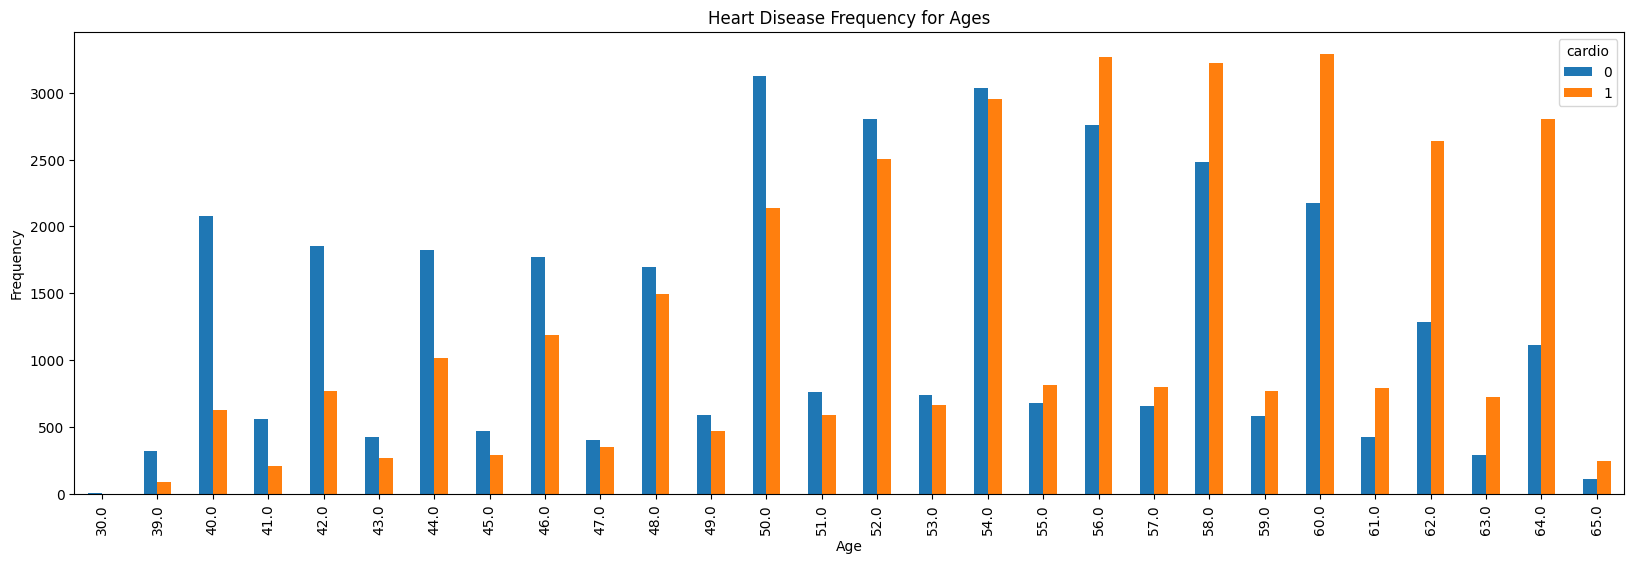

In [14]:
pd.crosstab(data.age,data.cardio).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

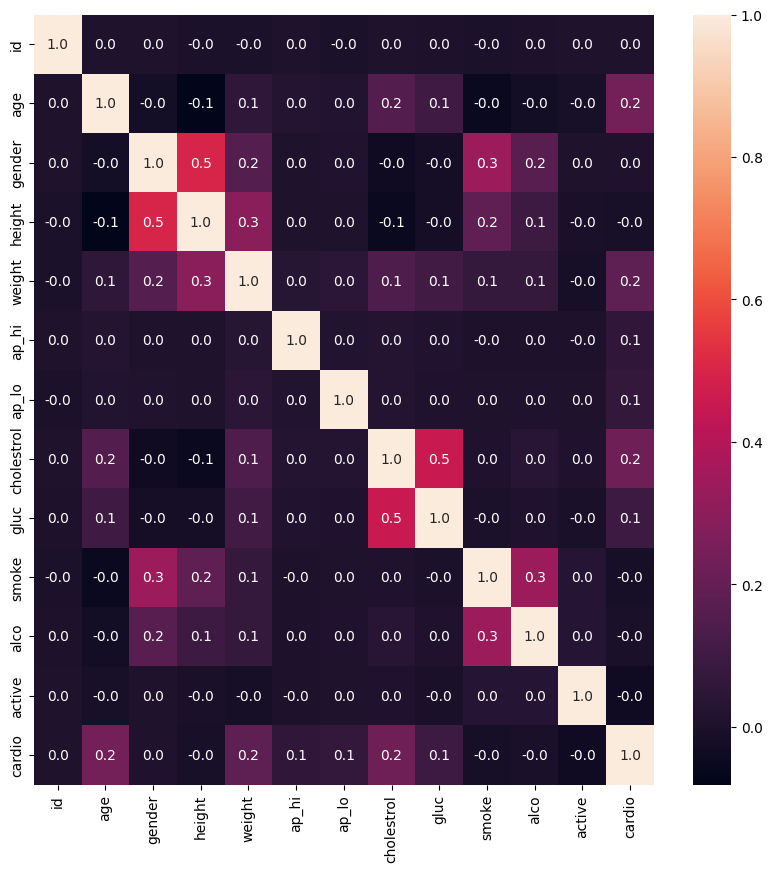

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True,fmt='.1f')
plt.show()

In [16]:
# Step 1: Data Preparation
X = np.array(data.drop(['cardio'], axis=1))  # Features
y = np.array(data['cardio'])  # Target

In [17]:
# Standardizing the data
mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

In [18]:
from sklearn.model_selection import train_test_split

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


In [19]:
# Convert target variable into categorical labels
Y_train = to_categorical(y_train, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)
print (Y_train.shape)
print (Y_train[:10])

(56000, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [18]:
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [19]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-addons
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [1]:
!pip install tensorflow==2.15 tensorflow-addons==0.23

  Using cached tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached wrapt-1.14.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [20]:
from tensorflow_addons.optimizers import LAMB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
# Build the model (same as before)
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))  # Use softmax for binary classification with 2 output nodes

# Compile the model with LAMB optimizer
model.compile(optimizer=LAMB(learning_rate=0.001, weight_decay_rate=0.01),
              loss='categorical_crossentropy',  # For binary classification with softmax
              metrics=['accuracy'])

# Early stopping to avoid overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Fit the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, Y_test),
                    callbacks=[es], verbose=1)

Epoch 1/100
1750/1750 [==============================] - 6s 2ms/step - loss: 0.6590 - accuracy: 0.6429 - val_loss: 0.5606 - val_accuracy: 0.7258
Epoch 2/100
1750/1750 [==============================] - 4s 2ms/step - loss: 0.5711 - accuracy: 0.7154 - val_loss: 0.5551 - val_accuracy: 0.7331
Epoch 3/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.5632 - accuracy: 0.7221 - val_loss: 0.5507 - val_accuracy: 0.7335
Epoch 4/100
1750/1750 [==============================] - 4s 2ms/step - loss: 0.5606 - accuracy: 0.7238 - val_loss: 0.5504 - val_accuracy: 0.7351
Epoch 5/100
1750/1750 [==============================] - 4s 2ms/step - loss: 0.5591 - accuracy: 0.7265 - val_loss: 0.5462 - val_accuracy: 0.7344
Epoch 6/100
1750/1750 [==============================] - 3s 2ms/step - loss: 0.5573 - accuracy: 0.7273 - val_loss: 0.5486 - val_accuracy: 0.7336
Epoch 7/100
1750/1750 [==============================] - 4s 2ms/step - loss: 0.5575 - accuracy: 0.7268 - val_loss: 0.5527 - val_ac

In [21]:
# Get predictions and evaluate the model
categorical_pred = np.argmax(model.predict(X_test), axis=1)
y_test_int = np.argmax(Y_test, axis=1)

# Print results
print('Results for Categorical Model with LAMB Optimizer')
print(f"Accuracy: {accuracy_score(y_test_int, categorical_pred)}")
print(classification_report(y_test_int, categorical_pred))

438/438 [==============================] - 1s 940us/step
Results for Categorical Model with LAMB Optimizer
Accuracy: 0.7392857142857143
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      6988
           1       0.75      0.71      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

